### 代码实现

注意本代码反向传播中，提到的未激活的误差(error_next_layer_before_active)指A

$$
A =\frac {\partial loss}{\partial Z} * \frac {\partial Z}{\partial Y}
$$
### 核心函数如下





In [ ]:
def backward_layer(pre_layer_after_active,error_next_layer_before_active,weight,bias,batch,lr,debug=False):
    bias_gradient = np.sum(error_next_layer_before_active,axis=0)/batch
    error_pre_layer_before_active = error_next_layer_before_active @ weight.T
    weight_step = weight - weight_gradient * lr
    bias_step = bias - bias_gradient * lr
    return weight_step,bias_step,error_pre_layer_before_active

def get_before_active(forward_before_active,error_after):
    return sigmoid_grad(forward_before_active) * error_after

def backward_layer_and_get_before_active(forward_pre_layer_before_active,
                                         forward_pre_layer_after_active,
                                         backward_error_next_layer_before_active, weight, bias, batch, lr,debug=False):
    w,b,ep=backward_layer(forward_pre_layer_after_active, backward_error_next_layer_before_active, weight, bias, batch, lr,debug)
    return w,b,get_before_active(forward_pre_layer_before_active,ep)


# 完整代码

In [145]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x_):
    return 1 / (1 + np.exp(-x_))


def sigmoid_grad(x_):
    return (1.0 - sigmoid(x_)) * sigmoid(x_)
#pre_layer_after_active  前向传播激活后
#error_next_layer_before_active 反向传播激活前（已经进入过激活层了）
def backward_layer(pre_layer_after_active,error_next_layer_before_active,weight,bias,batch,lr,debug=False):
    if debug :
        print("pre_layer_after_active",pre_layer_after_active.shape)
        print("error_next_layer_before_active",error_next_layer_before_active.shape)
    weight_gradient = pre_layer_after_active.T @ error_next_layer_before_active
    bias_gradient = np.sum(error_next_layer_before_active,axis=0)/batch
    error_pre_layer_before_active = error_next_layer_before_active @ weight.T
    weight_step = weight - weight_gradient * lr
    bias_step = bias - bias_gradient * lr
    return weight_step,bias_step,error_pre_layer_before_active

def get_before_active(forward_before_active,error_after):
    return sigmoid_grad(forward_before_active) * error_after

def backward_layer_and_get_before_active(forward_pre_layer_before_active,
                                         forward_pre_layer_after_active,
                                         backward_error_next_layer_before_active, weight, bias, batch, lr,debug=False):
    w,b,ep=backward_layer(forward_pre_layer_after_active, backward_error_next_layer_before_active, weight, bias, batch, lr,debug)
    return w,b,get_before_active(forward_pre_layer_before_active,ep)

class BP:
    def __init__(self, input_size, hidden_size, output_size, hidden_cnt,batcH_size=100,learn_rate=0.02):
        self.in_layer = None
        self.hidden_layer_before_active = None
        self.hidden_layer = None
        self.out_layer = None
        self.batch_size = None
        self.hidden_cnt = hidden_cnt
        self.weight_in_hid = np.random.rand(input_size, hidden_size)
        self.bias_hid = np.random.rand(hidden_size)
        self.hidden_mid_before_active = []
        self.hidden_mid_after_active = []
        self.hidden_mid_weight = np.random.rand(hidden_cnt,hidden_size, hidden_size)
        self.hidden_mid_bias = np.random.rand(hidden_cnt,hidden_size)
        self.weight_hid_out = np.random.rand(hidden_size, output_size)
        self.bias_out = np.random.rand(output_size)
        self.learn_rate = learn_rate

    def forward(self, data):
        self.hidden_mid_before_active = []
        self.hidden_mid_after_active = []
        for i in range(self.hidden_cnt):
            self.hidden_mid_before_active.append(None)
            self.hidden_mid_after_active.append(None)
        self.batch_size = data.shape[0]
        self.in_layer = data
        self.hidden_layer_before_active = self.in_layer @ self.weight_in_hid + self.bias_hid
        self.hidden_layer = sigmoid(self.hidden_layer_before_active)
        # 第一层特殊处理
        self.hidden_mid_before_active[0]=self.hidden_layer @ self.hidden_mid_weight[0] + self.hidden_mid_bias[0]
        self.hidden_mid_after_active[0]=self.hidden_mid_before_active[0]
        
        i = int(1)
        while i < self.hidden_cnt:
            self.hidden_mid_before_active[i]=self.hidden_mid_after_active[i-1]@self.hidden_mid_weight[i] + self.hidden_mid_bias[i]
            self.hidden_mid_after_active[i]=sigmoid(self.hidden_mid_before_active[i])
            i = i + 1
        assert len(self.hidden_mid_before_active) == self.hidden_cnt,'error hidden'
        self.out_layer = self.hidden_mid_after_active[self.hidden_cnt-1] @ self.weight_hid_out + self.bias_out
        return self.out_layer

    def backward(self, label):
        loss = ((self.out_layer - label) * (self.out_layer - label)).mean()
        error_out = (self.out_layer - label)
        self.weight_hid_out,self.bias_out,pre_before=backward_layer_and_get_before_active(
                        forward_pre_layer_before_active=self.hidden_mid_before_active[self.hidden_cnt - 1]
                       ,forward_pre_layer_after_active=self.hidden_mid_after_active[self.hidden_cnt - 1]
                       ,backward_error_next_layer_before_active=error_out
                       ,weight=self.weight_hid_out
                       ,bias=self.bias_out
                       ,batch=self.batch_size
                       ,lr=self.learn_rate
        )
        i = self.hidden_cnt - 1
        while i > 0:
            self.hidden_mid_weight[i],self.hidden_mid_bias[i],pre_before=backward_layer_and_get_before_active(
                            forward_pre_layer_before_active=self.hidden_mid_before_active[i - 1]
                           ,forward_pre_layer_after_active=self.hidden_mid_after_active[i - 1]
                           ,backward_error_next_layer_before_active=pre_before
                           ,weight=self.hidden_mid_weight[i]
                           ,bias=self.hidden_mid_bias[i]
                           ,batch=self.batch_size
                           ,lr=self.learn_rate,debug=False)
            i = i - 1
            
        self.hidden_mid_weight[0],self.hidden_mid_bias[0],pre_before=backward_layer_and_get_before_active(
                            forward_pre_layer_before_active=self.hidden_layer_before_active
                           ,forward_pre_layer_after_active=self.hidden_layer
                           ,backward_error_next_layer_before_active=pre_before
                           ,weight=self.hidden_mid_weight[0]
                           ,bias=self.hidden_mid_bias[0]
                           ,batch=self.batch_size
                           ,lr=self.learn_rate,
                            debug=False
        )
        self.weight_in_hid,self.bias_hid,_=backward_layer_and_get_before_active(
                            forward_pre_layer_before_active=self.in_layer
                           ,forward_pre_layer_after_active=self.in_layer
                           ,backward_error_next_layer_before_active=pre_before
                           ,weight=self.weight_in_hid
                           ,bias=self.bias_hid
                           ,batch=self.batch_size
                           ,lr=self.learn_rate
        )
        return loss

    def train(self, data, label, step=10000):
        loss_array = []
        for i in range(step):
            self.forward(data)
#             print(self.backward(label).shape)
            ll = self.backward(label)
            loss_array.append(ll)
#             print(ll)
        return np.array(loss_array)


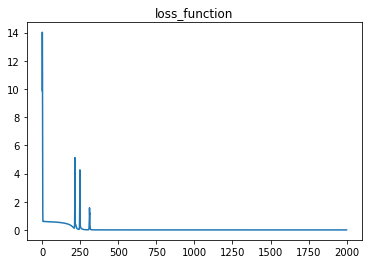

In [146]:
bp = BP(1, 4, 1, 2,learn_rate=0.01)
data = np.linspace(-2, 2, 60)
data.shape = 60, 1
loss = bp.train(data, np.sin(data), step=2000)
plt.title('loss_function')
plt.plot(loss)
plt.show()

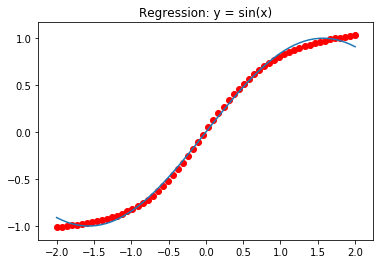

In [147]:
plt.plot(data, np.sin(data))
plt.scatter(data, bp.forward(data),color='r')
plt.title('Regression: y = sin(x)')
plt.show()

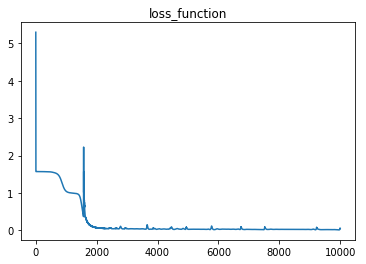

In [131]:
bp2 = BP(1, 4, 1,2,learn_rate=0.01)
data = np.linspace(-2, 2, 40)
data.shape = 40, 1
loss = bp2.train(data, data * data)
plt.title('loss_function')
plt.plot(loss)
plt.show()

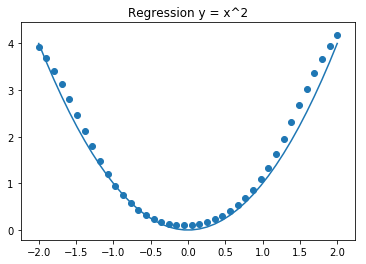

In [132]:
plt.plot(data, data * data)
plt.scatter(data, bp2.forward(data))
plt.title("Regression y = x^2")
plt.show()

In [137]:
bp3 = BP(2, 4, 1, 1,learn_rate=0.01)
data = np.linspace(0, 2, 40)
data.shape = -1, 2
label = np.sum(data, axis=1)
label.shape = -1, 1
sequence = np.linspace(0, 20, 20)
loss = bp3.train(data, label, step=1000)
print('x1',data[:,0])
print('x2',data[:,1])
# print('x1+x2',label)

x1 [0.         0.1025641  0.20512821 0.30769231 0.41025641 0.51282051
 0.61538462 0.71794872 0.82051282 0.92307692 1.02564103 1.12820513
 1.23076923 1.33333333 1.43589744 1.53846154 1.64102564 1.74358974
 1.84615385 1.94871795]
x2 [0.05128205 0.15384615 0.25641026 0.35897436 0.46153846 0.56410256
 0.66666667 0.76923077 0.87179487 0.97435897 1.07692308 1.17948718
 1.28205128 1.38461538 1.48717949 1.58974359 1.69230769 1.79487179
 1.8974359  2.        ]


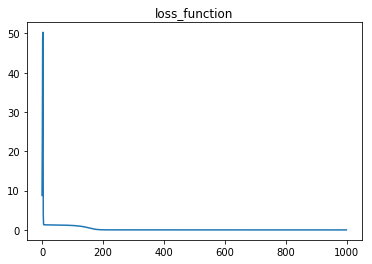

In [138]:
plt.title('loss_function')
plt.plot(loss)
plt.show()

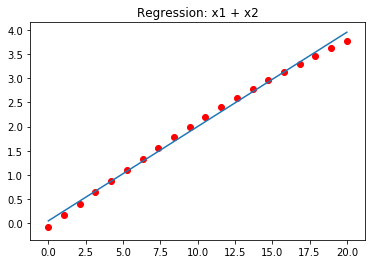

In [139]:
plt.plot(sequence, label)
plt.scatter(sequence, bp3.forward(data),color = 'r')
plt.title('Regression: x1 + x2')
plt.show()